In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks

(array([18322, 18353, 18367], dtype=int64),
 <a list of 3 Text xticklabel objects>)

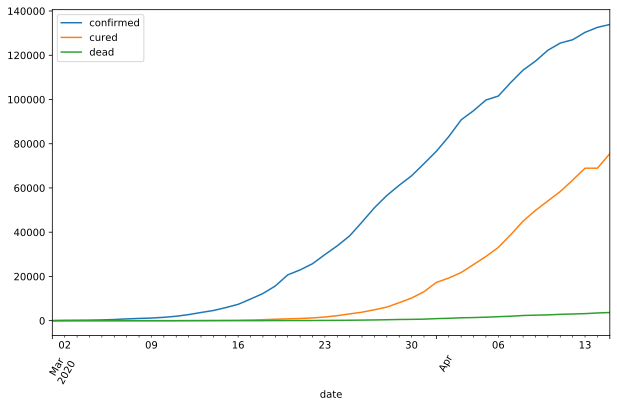

In [3]:
# 01: prepare data
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_excel("./data/covid_19_Deutschland.xlsx",sheet_name=0)
df.head()
df.plot(x = "date",y = ["confirmed","cured","dead"],figsize=(10,6))
plt.xticks(rotation=60)

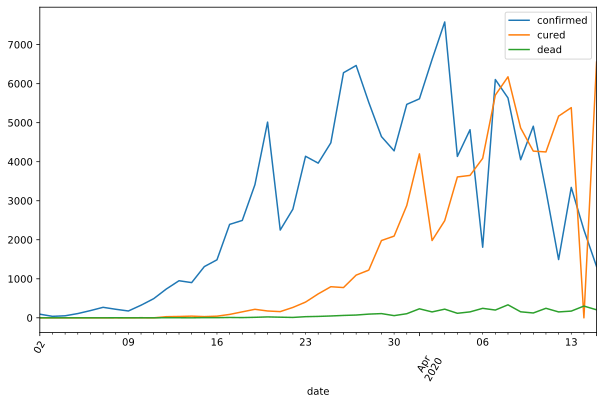

In [4]:
dfdata = df.set_index("date")

#train diff
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")
dfdiff.plot(x = "date",y = ["confirmed","cured","dead"],figsize=(10,6))
plt.xticks(rotation=60)

#train total
#dfdiff=dfdata
#dfdiff = dfdiff.reset_index("date")

dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [5]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#print(len(list(ds_data.as_numpy_iterator())))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

In [6]:
# 02: define model
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

In [7]:
# 03: train model
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

logdir = os.path.join(".","data","logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

==] - 0s 89ms/step - loss: 133896.7188
Epoch 62/500
1/1 [==============================] - 0s 66ms/step - loss: 121577.6250
Epoch 63/500
1/1 [==============================] - 0s 75ms/step - loss: 110170.4141
Epoch 64/500
1/1 [==============================] - 0s 66ms/step - loss: 99628.0625
Epoch 65/500
1/1 [==============================] - 0s 196ms/step - loss: 89904.1094
Epoch 66/500
1/1 [==============================] - 0s 63ms/step - loss: 80952.8594
Epoch 67/500
1/1 [==============================] - 0s 55ms/step - loss: 72729.5703
Epoch 68/500
1/1 [==============================] - 0s 55ms/step - loss: 65190.5664
Epoch 69/500
1/1 [==============================] - 0s 58ms/step - loss: 58293.4219
Epoch 70/500
1/1 [==============================] - 0s 60ms/step - loss: 51997.0781
Epoch 71/500
1/1 [==============================] - 0s 62ms/step - loss: 46261.8438
Epoch 72/500
1/1 [==============================] - 0s 62ms/step - loss: 41049.5078
Epoch 73/500
1/1 [================

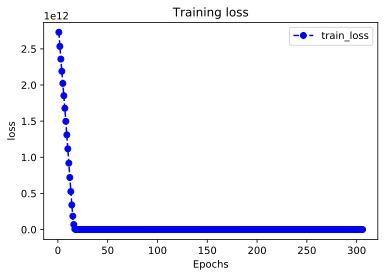

In [8]:
# 04: evaluate model
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()
plot_metric(history,"loss")

,confirmed,cured,dead
69,0.0,0.0,0.0
70,0.0,-0.0,-0.0
71,0.0,0.0,0.0
72,0.0,-0.0,-0.0
73,0.0,0.0,0.0


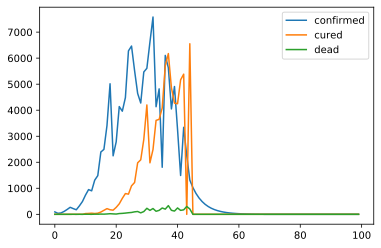

In [28]:
# 05: use model
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed","cured","dead"]].copy()
#dfresult.tail()

#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)


dfresult.iloc[0:100].plot()
dfresult.query("confirmed==0").head()
#dfresult.query("cured==0").head()
#dfresult.query("dead==0").head()

(array([737485., 737499., 737516., 737530., 737546., 737560., 737577.]),
 <a list of 7 Text xticklabel objects>)

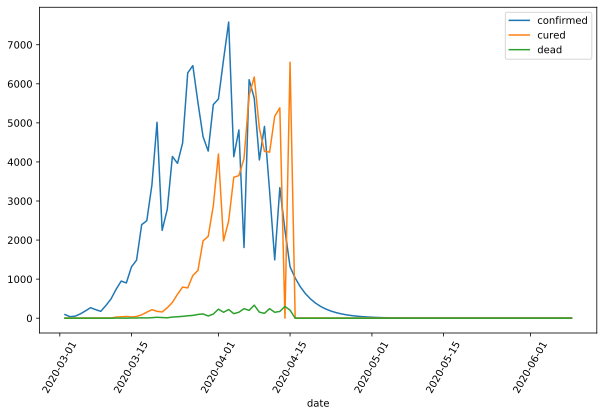

In [29]:
# add date in result
from datetime import date,timedelta
start = date(2020,3,2)
dfresult["date"]=None
for i in dfresult.index:
    dfresult["date"].at[i]=start+timedelta(days=i)
#dfresult.head()
dfresult.iloc[0:100].plot(x="date",y=["confirmed","cured","dead"],figsize=(10,6))
plt.xticks(rotation=60)



In [30]:
temp = dfresult[["confirmed","cured","dead","date"]].copy()
insertRow=pd.DataFrame([[57,14,0,date(2020,3,1)]],columns=["confirmed","cured","dead","date"])
insertRow
dfresult_total=insertRow.append(temp,ignore_index=True)

#dfresult_total=dfresult_total.set_index("date")
#dfresult_total.head()

for i in temp.index:
    dfresult_total.loc[i+1,"confirmed"]=dfresult_total.loc[i,"confirmed"]+dfresult_total.loc[i+1,"confirmed"]
    dfresult_total.loc[i+1,"cured"]=dfresult_total.loc[i,"cured"]+dfresult_total.loc[i+1,"cured"]    
    dfresult_total.loc[i+1,"dead"]=dfresult_total.loc[i,"dead"]+dfresult_total.loc[i+1,"dead"]
dfresult_total.columns=["confirmed_total","cured_total","dead_total","date"]
dfresult.columns=["confirmed_add","cured_add","dead_add","date"]
dfresult_total=pd.merge(dfresult_total,dfresult)
dfresult_total=dfresult_total[["date","confirmed_total","cured_total","dead_total","confirmed_add","cured_add","dead_add"]]
dfresult_total.head()


,date,confirmed_total,cured_total,dead_total,confirmed_add,cured_add,dead_add
0,2020-03-02,150.0,14.0,0.0,93.0,0.0,0.0
1,2020-03-03,188.0,14.0,0.0,38.0,0.0,0.0
2,2020-03-04,240.0,14.0,0.0,52.0,0.0,0.0
3,2020-03-05,349.0,14.0,0.0,109.0,0.0,0.0
4,2020-03-06,534.0,14.0,0.0,185.0,0.0,0.0


In [47]:
dfresult_total.to_excel("covid-19_prediction_rnn.xlsx")

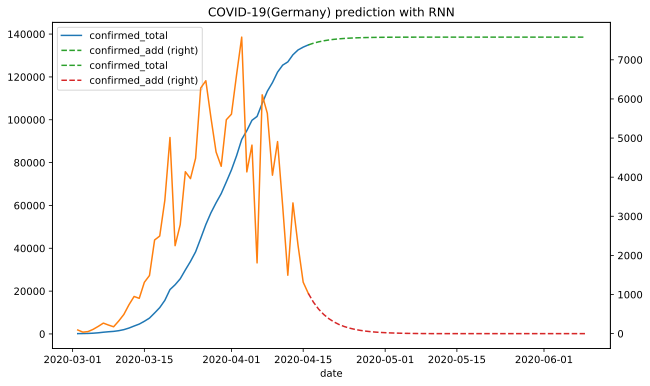

In [50]:
aax=dfresult_total.iloc[0:46].plot(x="date",y=["confirmed_total","confirmed_add"],figsize=(10,6),secondary_y=["confirmed_add"]) 
bbx=dfresult_total.iloc[45:100].plot(x="date",y=["confirmed_total","confirmed_add"],ax=aax,style='--',secondary_y=["confirmed_add"])


plt.xticks(rotation=60)
plt.title("COVID-19(Germany) prediction with RNN") 
bbx.get_figure().savefig("covid-19_prediction_rnn.png")